# Playground for plotting refactoring.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from geodatasets import get_path
from mapclassify import classify
from matplotlib import colormaps, colors
from matplotlib.collections import LineCollection, PatchCollection

import geopandas as gpd
from geopandas.plotting import _plot_polygon_collection

Use Guerry data. It has categorical (Region) as well as plenty of continuous. Has Polygon and MultiPolygon geometry.

In [2]:
df = gpd.read_file(get_path("geoda guerry"))

## PolygonPatch working on MultiPolygons

Try getting PolygonPatch for a MultiPolygon so we don't need to explode.

In [3]:
def _PolygonPatch(polygon, **kwargs):
    """Construct a matplotlib patch from a (Multi)Polygon geometry.

    The `kwargs` are those supported by the matplotlib.patches.PathPatch class
    constructor. Returns an instance of matplotlib.patches.PathPatch.

    To ensure proper rendering on the matplotlib side, winding order of individual
    rings needs to be normalized as the order is what matplotlib uses to determine
    if a Path represents a patch or a hole.

    Example (using Shapely Point and a matplotlib axes)::

        b = shapely.geometry.Point(0, 0).buffer(1.0)
        patch = _PolygonPatch(b, fc='blue', ec='blue', alpha=0.5)
        ax.add_patch(patch)

    GeoPandas originally relied on the descartes package by Sean Gillies
    (BSD license, https://pypi.org/project/descartes) for PolygonPatch, but
    this dependency was removed in favor of the below matplotlib code.
    """
    from matplotlib.patches import PathPatch
    from matplotlib.path import Path

    if polygon.geom_type == "Polygon":
        path = Path.make_compound_path(
            Path(np.asarray(polygon.exterior.coords)[:, :2], closed=True),
            *[
                Path(np.asarray(ring.coords)[:, :2], closed=True)
                for ring in polygon.interiors
            ],
        )
    else:
        paths = []
        for part in polygon.geoms:
            # exteriors
            paths.append(Path(np.asarray(part.exterior.coords)[:, :2], closed=True))
            # interiors
            for ring in part.interiors:
                paths.append(Path(np.asarray(ring.coords)[:, :2], closed=True))
        path = Path.make_compound_path(*paths)

    return PathPatch(path, **kwargs)

## Collections that are understood by Legend

PatchCollection is not directly supported by a legend.

Subclass.

In [4]:
class GeoPandasPolyCollection(PatchCollection): ...

Assign default handler to our custom subclass.

In [5]:
from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerPolyCollection

Legend.update_default_handler_map({GeoPandasPolyCollection: HandlerPolyCollection()})

Test

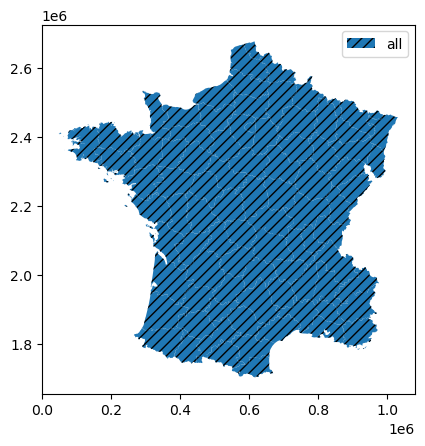

In [6]:
f, ax = plt.subplots()
collection = GeoPandasPolyCollection(
    [_PolygonPatch(poly) for poly in df.geometry], label="all", hatch="///"
)
ax.add_collection(collection)
ax.autoscale_view()
ax.legend()
ax.set_aspect("equal")

## Categorical plotting

Each category shall be plotted as its own collection.

<Axes: >

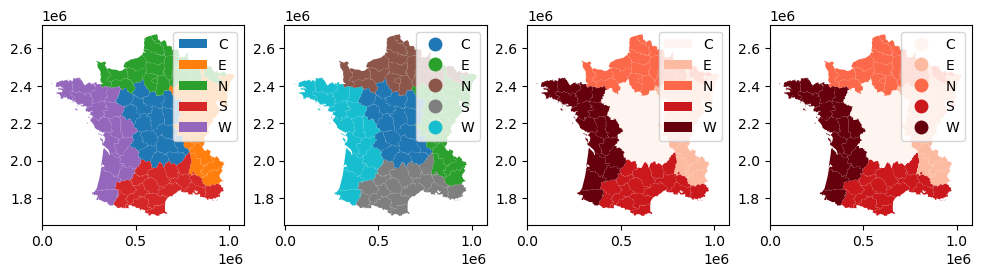

In [7]:
f, ax = plt.subplots(1, 4, figsize=(12, 6))

grouped = df.groupby("Region")

for i, (name, group) in enumerate(grouped["geometry"]):
    _plot_polygon_collection(
        ax=ax[0],
        geoms=group,
        label=name,
        facecolor=colormaps["tab10"](i),  # use i for listed colormap
    )
ax[0].legend()
ax[0].set_aspect("equal")

df.plot("Region", ax=ax[1], legend=True, cmap="tab10")

for i, (name, group) in enumerate(grouped["geometry"]):
    _plot_polygon_collection(
        ax=ax[2],
        geoms=group,
        label=name,
        facecolor=colormaps["Reds"](
            i / (grouped.ngroups - 1)
        ),  # do not use i but i / N for linear cmap
    )
ax[2].legend()
ax[2].set_aspect("equal")

df.plot("Region", ax=ax[3], legend=True, cmap="Reds")

The code above yields different colours than GeoPandas 1.1.1. The reason is that in 1.1.1, the integer codes of categories are stretched as values alongside the colormap, while the code above iterates over the colormap. The code above is consistent with matplotlib but it is technically a breaking change. In my optinion, iterating over the cmap is the correct behaviour, if the colormap is categorical. If we pass a continuous colormap like Reds, this does not work and we need to stretch along the cmap. We could iterate over `ListedColormap` and stretch alongside `LinearSegmentedColormap`. That is also what [docs](https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.Colormap.html#matplotlib.colors.Colormap) say - for ints (aka categories), use index. For floats (aka continuous) use interval 0...1. This assumes you are not using linear cmap with categories. But we shall support that nontheless. This also solves the annoying issue when plotting two categories, you get blue and light blue...

**NOTE: Continuous attribute with a discrete `scheme` shall not be treated as a categorical plot as it is now.**

## Colorbar

In [8]:
rivers = gpd.read_file(get_path("eea large_rivers")).explode()

I am using rivers and exploding them as LineCollection can't consume anything Multi*.

Get automatically derived colorbar.

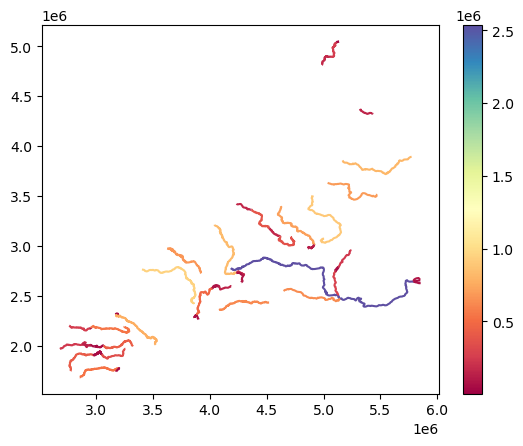

In [ ]:
fig, ax = plt.subplots()

segments = [np.array(linestring.coords)[:, :2] for linestring in rivers.geometry]
collection = LineCollection(segments, label="len")
collection.set_array(rivers.length)
collection.set_cmap("Spectral")

ax.add_collection(collection)

ax.autoscale_view()
fig.colorbar(collection)  # this is the important bit

This is nice as matplotlib can be given array of values and cmap and deals with everything on its own. When this breaks is when you have mixed geometry types. Then you would get a colorbar per geom type. We would need to get vmin, vmax prior plotting to send it to all collections and then call colorbar from one of them.

Get a discrete map using mapclassify.

In [23]:
cl = classify(rivers.length, scheme="naturalbreaks", k=10)

In [24]:
norm = colors.BoundaryNorm(
    boundaries=[rivers.length.min()] + list(cl.bins), ncolors=256, extend="min"
)

`extend` above is just an illustration on what shall we do when `vmin` is larger than `y.min()`.

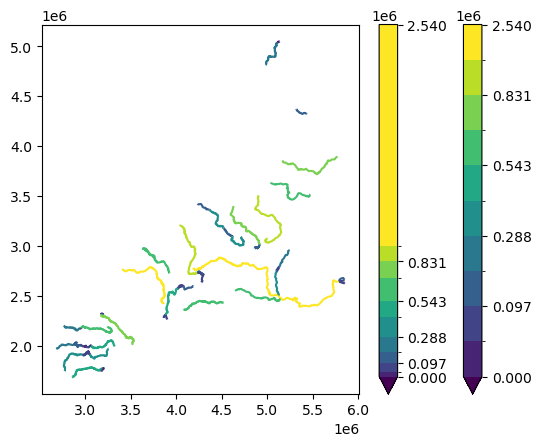

In [25]:
fig, ax = plt.subplots()

segments = [np.array(linestring.coords)[:, :2] for linestring in rivers.geometry]
collection = LineCollection(
    segments, array=rivers.length, cmap="viridis", label="len", norm=norm
)

ax.add_collection(collection)

ax.autoscale_view()
fig.colorbar(collection, spacing="uniform")
fig.colorbar(collection, spacing="proportional")

With a properly set `BoundaryNorm`, the discrete colorbar is automatically generated. The `spacing` keyword can then control the spacing of ticks. That is equal to `scale` keyword in `legend_kwds` in `explore`.

If we want to get a categorical legend out of this, everything gets way more complicated as we would need to generate an ordered Categorical with custom labels and pass it via categorical plotting mechanism. Annoying but feasible:

In [109]:
y = pd.Categorical(
    np.take(cl.get_legend_classes(), cl.yb), categories=cl.get_legend_classes()
)

In [ ]:
segments = [np.array(linestring.coords)[:, :2] for linestring in rivers.geometry]
collection = LineCollection(
    segments, array=rivers.length, cmap="viridis", label="len", norm=norm
)

Below is an adaptation of the code used above to use LineCollection instead of GeoPandasPolyCollection.

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_29327/1952854666.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = rivers.groupby(y)


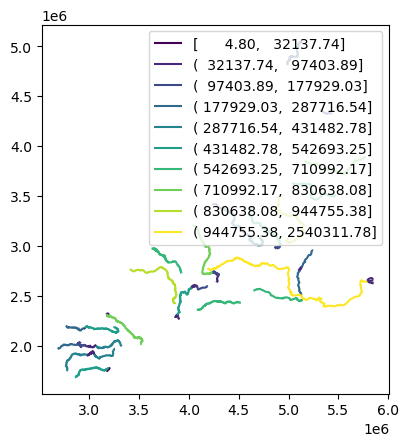

In [113]:
f, ax = plt.subplots()

grouped = rivers.groupby(y)

for i, (name, group) in enumerate(grouped["geometry"]):
    segments = [np.array(linestring.coords)[:, :2] for linestring in group]
    collection = LineCollection(
        segments, color=colormaps["viridis"](i / (grouped.ngroups - 1)), label=name
    )
    ax.add_collection(collection)
    ax.autoscale_view()

ax.legend()
ax.set_aspect("equal")

### Ensure that colorbar is by default the height of the figure

Since we change the aspect, in landscape figures is colorbar typically taller than the map. We don't want that.

In [14]:
subset = rivers[rivers.NAME.isin(["Danube", "Elbe"])]

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

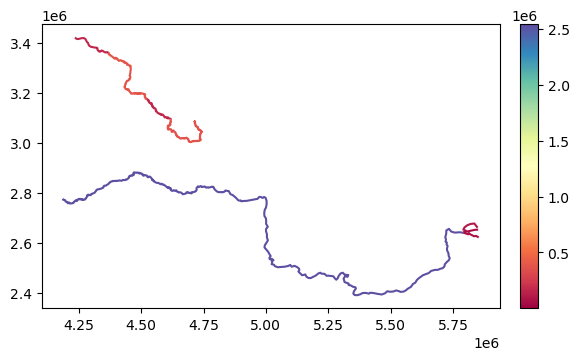

In [23]:
fig, ax = plt.subplots()

segments = [np.array(linestring.coords)[:, :2] for linestring in subset.geometry]
collection = LineCollection(segments, array=subset.length, cmap="Spectral", label="len")

ax.add_collection(collection)

ax.autoscale_view()
ax.set_aspect("equal")

# we need to create an specific axis for the colorbar, it seems

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.2)
fig.colorbar(collection, cax=cax)

This behaves slightly differently than now as the space for the colorbar is no longer stolen from the axist itself, so there will likely be a minor difference in the figure even when it already is the same height.

## Map color to value

For categorical plots, we should allow plotting category directly to color via a dict in cmap.

In [25]:
nybb = gpd.read_file(get_path("nybb"))

In [27]:
colors = {
    "Staten Island": "pink",
    "Queens": "red",
    "Brooklyn": "green",
    "Manhattan": "blue",
    "Bronx": "yellow",
}

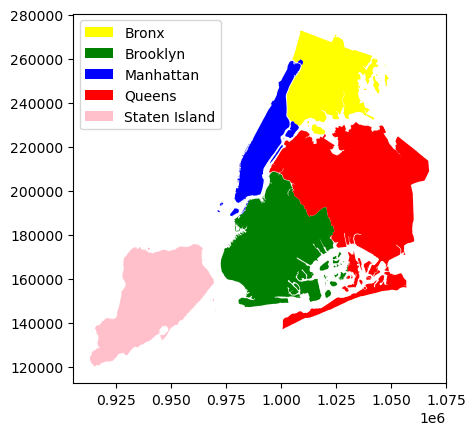

In [31]:
# mimicking plot("BoroName", cmap=colors)

f, ax = plt.subplots()

grouped = nybb.groupby("BoroName")

for i, (name, group) in enumerate(grouped["geometry"]):
    _plot_polygon_collection(
        ax=ax,
        geoms=group,
        label=name,
        facecolor=colors[name],  # pull color directly
    )
ax.legend(loc="upper left")
ax.set_aspect("equal")

The same shall be applied to all the other styling keywords.

In [32]:
hatches = {
    "Staten Island": "/",
    "Queens": "//",
    "Brooklyn": "|",
    "Manhattan": "+",
    "Bronx": "///",
}

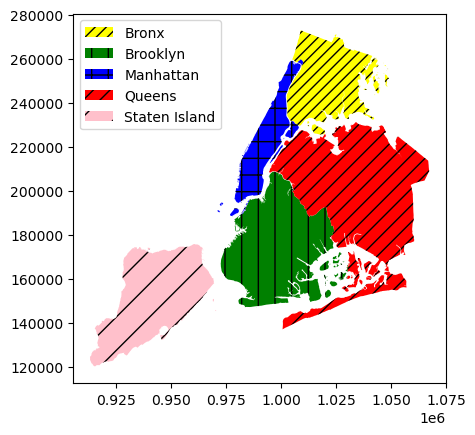

In [33]:
# mimicking plot("BoroName", cmap=colors, hatch=hatches)

f, ax = plt.subplots()

grouped = nybb.groupby("BoroName")

for i, (name, group) in enumerate(grouped["geometry"]):
    _plot_polygon_collection(
        ax=ax,
        geoms=group,
        label=name,
        facecolor=colors[name],  # pull color directly
        hatch=hatches[name],
    )
ax.legend(loc="upper left")
ax.set_aspect("equal")